# Dew Point and Pitching

Using pitch data collected from games in Cincinnati to predict the probability that a pitch was affected by a dew point greater than 65 degree F

Selah Dean 

In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

import os
os.chdir("C:/Users/sgdea/OneDrive - Case Western Reserve University/Documents/College/8. Misc/Applications/Summer 2024/Reds")

In [43]:
#Loading in the data provided
data = pd.read_csv("data.csv")

In [44]:
#Determining how many different pitchers were included in the data 
data['PITCHER_KEY'].unique()

array([668881, 518585, 622065, 571882, 571656, 664139, 666157, 665665,
       664747, 668933, 656818, 570666, 669270, 643361, 668984, 613564,
       571912, 686651, 608371, 596133, 594902, 611093, 641427, 674285,
       682227, 671096, 650960, 691094, 621219, 594580, 622088, 686730,
       592741, 664028, 592527, 683175, 680689], dtype=int64)

First I looked at the distribution of a few of the features for the fastballs of a one of the pitchers 

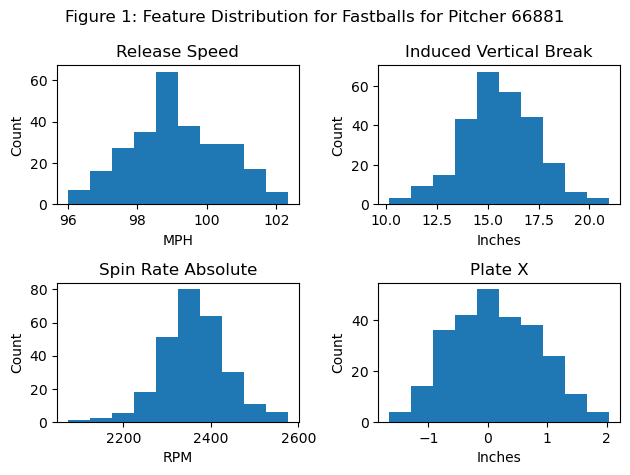

In [46]:
pitcher = data[data['PITCHER_KEY']==668881]
pitcher_fb = pitcher[pitcher['PITCH_TYPE_TRACKED_KEY']=="FB"]
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(pitcher_fb['RELEASE_SPEED'])
axs[0, 0].set_title('Release Speed')
axs[0,0].set_xlabel('MPH')
axs[0,0].set_ylabel('Count')
axs[0, 1].hist(pitcher_fb['INDUCED_VERTICAL_BREAK'])
axs[0, 1].set_title('Induced Vertical Break')
axs[0,1].set_xlabel('Inches')
axs[0,1].set_ylabel('Count')
axs[1, 0].hist(pitcher_fb['SPIN_RATE_ABSOLUTE'])
axs[1, 0].set_title('Spin Rate Absolute')
axs[1,0].set_xlabel('RPM')
axs[1,0].set_ylabel('Count')
axs[1, 1].hist(pitcher_fb['PLATE_X'])
axs[1, 1].set_title('Plate X')
axs[1,1].set_xlabel('Inches')
axs[1,1].set_ylabel('Count')
fig.suptitle("Figure 1: Feature Distribution for Fastballs for Pitcher 66881")
fig.tight_layout()
#fig.savefig("figure1.jpg")

The figures showed an approximately normal distribution for each feature which means that anomaly detection is a reasonable choice for determining the probability a pitch was affected by a high dew point. 

Next I defined a function that will predict the probability that a pitch was affected by a dew point of greater than 65 degrees F by fitting an Isolation Forest model and scaling the results of the anomaly scores by the minimum and maximum. 

In [47]:
def find_prob(X):
    model = IsolationForest(random_state=1).fit(X)
    anomaly_scores = model.decision_function(X)
    anomaly_probabilities = 1 - MinMaxScaler().fit_transform(anomaly_scores.reshape(-1,1))
    return anomaly_probabilities 
    

Since the distributions for each pitcher and each pitch type are different I wanted to find the model for each combination of pitcher and pitch type. I created a loop that went through each pitcher and each pitch type they throw and ran the function I created above. 

In [48]:
final_predictions = np.empty((0,2))
for pitcher_key in data['PITCHER_KEY'].unique(): 
    pitcher = data[data['PITCHER_KEY']==pitcher_key]
    for pitch_type in pitcher['PITCH_TYPE_TRACKED_KEY'].unique(): 
        pitcher_bytype = pitcher[pitcher['PITCH_TYPE_TRACKED_KEY']==pitch_type]
        prob = find_prob(pitcher_bytype.iloc[:, 15:25])
        predictions = np.column_stack((np.array(pitcher_bytype['PID']), prob))
        final_predictions = np.vstack((final_predictions, predictions))
        

My last step was to convert the final predictions array which contained the pitch id and probability into a dataframe to be saved a csv file

In [49]:
df = pd.DataFrame(final_predictions, columns =['PID', 'DEWPOINT_AFFECTED']) 
df.to_csv('submission.csv', index=False)